## Frozen Lake Introduction
- [Fronze Lake](https://gym.openai.com/envs/FrozenLake-v0/) is a simple game where you are on a frozen lake and you need to retrieve an item on the frozen lake where some parts are frozen and some parts are holes (if you walk into them you die)
- Actions: $\mathcal{A} = \{0, 1, 2, 3\}$
    1. LEFT: 0
    2. DOWN = 1
    3. RIGHT = 2
    4. UP = 3
- Whole lake is a 4 x 4 grid world, $\mathcal{S} = \{0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15\}$
    - ![](./images/gridworld.png)
- On each grid, there are 4 possibilities
    - S: starting point, safe (code = 'SFFF')
    - F: frozen surface, safe (code = 'FHFH')
    - H: hole, fall to your doom (code = 'FFFH')
    - G: goal, where the frisbee is located ('HFFG')
    - ![](./images/gridworld_examples.png)

### Goal of Frozen Lake
The key here is we want to get to **G** without falling into the hole **H** in the shortest amount of time

### Why Dynamic Programming?
In this game, we know our transition probability function and reward function, essentially the whole environment, allowing us to turn this game into a simple planning problem via dynamic programming through 4 simple functions: (1) policy evaluation (2) policy improvement (3) policy iteration or (4) value iteration

Before we explore how to solve this game, let's first understand how the game works in detail.

### Deterministic Policy Environment

In [1]:
# Import gym, installable via `pip install gym`
import gym

In [2]:
# Environment environment Slippery (stochastic policy, move left probability = 1/3) comes by default!
# If we want deterministic policy, we need to create new environment
# Make environment No Slippery (deterministic policy, move left = left)

gym.envs.register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

# You can only register once
# To delete any new environment
# del gym.envs.registry.env_specs['FrozenLakeNotSlippery-v0']

In [3]:
# Make the environment based on deterministic policy
env = gym.make('FrozenLakeNotSlippery-v0')

In [4]:
# State space
print(env.observation_space)

Discrete(16)


In [5]:
S_n = env.observation_space.n
print(S_n)

16


In [6]:
# We should expect to see 15 possible grids from 0 to 15 when
# we uniformly randomly sample from our observation space
for i in range(10):
    print(env.observation_space.sample())

8
7
0
8
0
7
10
5
14
14


In [7]:
# Action space
print(env.action_space)

Discrete(4)


In [8]:
A_n = env.action_space.n
print(A_n)

4


In [9]:
# We should expect to see 4 actions when
# we uniformly randomly sample:
#     1. LEFT: 0
#     2. DOWN = 1
#     3. RIGHT = 2
#     4. UP = 3
for i in range(10):
    print(env.action_space.sample())

3
0
0
0
0
3
3
3
1
3


####  Making Steps

In [47]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the 4x4 frozenlake gridworld
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [11]:
# Go left (action=0), nothing should happen, and we should stay at the starting point, because there's no grid on the left
env.reset()
action = 0
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 1: move to grid number 1 (unchanged)
# Prob = 1: deterministic policy, if we choose to go left, we'll go left
print(observation, reward, done, prob)

  (Left)
SFFF
FHFH
FFFH
HFFG
0 0.0 False {'prob': 1.0}


In [12]:
# Go down (action = 1), we should be safe as we step on frozen grid
env.reset()
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 4: move to grid number 4
# Prob = 1: deterministic policy, if we choose to go down we'll go down
print(observation, reward, done, prob)

  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False {'prob': 1.0}


In [13]:
# Go right (action = 2), we should be safe as we step on frozen grid
env.reset()
action = 2
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 1: move to grid number 1
# Prob = 1: deterministic policy, if we choose to go right we'll go right
print(observation, reward, done, prob)

  (Right)
SFFF
FHFH
FFFH
HFFG
1 0.0 False {'prob': 1.0}


In [14]:
# Go right twice (action = 2), we should be safe as we step on 2 frozen grids
env.reset()
action = 2
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 2: move to the right twice from grid 0 to grid 2
# Prob = 1: deterministic policy, if we choose to go right twice we'll go right twice
print(observation, reward, done, prob)

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
2 0.0 False {'prob': 1.0}


#### Dying: drop in hole grid 12,  H

In [15]:
# Go down thrice (action = 1), we will die as we step onto the grid with a hole
env.reset()
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 2: move to the right twice from grid 0 to grid 2
# Prob = 1: deterministic policy, if we choose to go right twice we'll go right twice
# Done = True because the game ends when we die (go onto hole grid (H) or finish the game (G))
print(observation, reward, done, prob)

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
12 0.0 True {'prob': 1.0}


#### Winning: get to grid 15, G

In [16]:
# Go right twice (action = 2), go down thrice (action = 1), go right once (action = 2)
env.reset()

# Right Twice
action = 2
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()

# Down Thrice
action = 1
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()
(observation, reward, done, prob) = env.step(action)
env.render()

# Right Once
action = 2
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 2: move to the right twice from grid 0 to grid 2
# Prob = 1: deterministic policy, if we choose to go right twice we'll go right twice
# Done = True because the game ends when we die (go onto hole grid (H) or finish the game (G))
print(observation, reward, done, prob)

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
15 1.0 True {'prob': 1.0}


### Non-deterministic Policy Environment

In [17]:
# Make the environment based on deterministic policy
env = gym.make('FrozenLake-v0')

In [18]:
# Go right once (action = 2), we should go to the right but we did not!
env.seed(8)
env.reset()
action = 2
(observation, reward, done, prob) = env.step(action)
env.render()

# Observation = 0: move to the right once from grid 0 to grid 1
# Prob = 1/3: non-deterministic policy, if we choose to go right, there's only a 1/3 probability we would go to the right and with this environment seed we did not
print(observation, reward, done, prob)

  (Right)
SFFF
FHFH
FFFH
HFFG
0 0.0 False {'prob': 0.3333333333333333}


In [19]:
# Try to go to the right 10 times, let's see how many times it goes to the right, by right we won't die because we would end up at the extreme right of grid 3
# See how it can go down/left/up/nothing instead of just right? 
# Intuitively when we are moving on a frozen lake, some times when we want to walk one direction we may end up in another direction as it's slippery
# Setting seed here of the environment so you can reproduce my results, otherwise stochastic policy will yield different results for each run
env.seed(8)
env.reset()
for i in range(10):
    action = 2
    (observation, reward, done, prob) = env.step(action)
    env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


### Custom Frozen Lake Non-deterministic Policy Environment
- Because original code from [OpenAI](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) only allows us to run `env.step(action)`, this is challenging if we want to do some visualization of our state-value and action-value (q-value) functions for learning
- Hence, we'll be copying the whole code from [OpenAI Frozen Lake implementation](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) and adding just one line to make sure we can get P via `self.P = P`
- This code is not important, you can just copy it

In [20]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}

# Generates a random valid map (one that has a path from start to goal)
# @params size, size of each side of the grid
# @prams p, probability that a tile is frozen
def generate_random_map(size=8, p=0.8):
    valid = False
    
    #BFS to check that it's a valid path
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True
        
        tmp = arr[r][c]
        arr[r][c] = "#"
        
        if r+1 < size and arr[r+1][c] not in '#H':
            if is_valid(arr, r+1, c) == True:
                arr[r][c] = tmp
                return True
        
        if c+1 < size and arr[r][c+1] not in '#H':
            if is_valid(arr, r, c+1) == True:
                arr[r][c] = tmp
                return True
        
        if r-1 >= 0 and arr[r-1][c] not in '#H':
            if is_valid(arr, r-1, c) == True:
                arr[r][c] = tmp
                return True
        
        if c-1 >= 0 and arr[r][c-1] not in '#H':
            if is_valid(arr,r, c-1) == True:
                arr[r][c] = tmp
                return True
        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F','H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        # New change because environment only allows step without
        # specific state for learning environment!
        self.P = P
        
        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

## Policy Evaluation

### Transition Probability Function
- $\mathcal{P}_{ss'}^a = \mathcal{P}(s' \vert s, a)  = \mathbb{P} [S_{t+1} = s' \vert S_t = s, A_t = a]$

#### Deterministic Environment 
- There's no probability distribution, if you decide to go left you'll go left
- Hence in this example, given `current_state = 8` and `action = 0` which is left, we will end up with `probability = 1` in `new_state = 9`

In [21]:
# Deterministic
env = FrozenLakeEnv(is_slippery=False)

current_state = 10  # State from S_n=16 State space
action = 0  # Left action from A_n=4 Action space
[(probability, new_state, reward, done)] = env.P[current_state][action]

print('Probability {}, New State {}'.format(probability, new_state))

Probability 1.0, New State 9


#### Stochastic Environment 
- Given $S_t = 10, A_t = 0$ in a stochastic environment, the transition probability functions indicate you can end up in grid 6, 9, 14 each with 1/3 probability:
    - $\mathbb{P} [S_{t+1} = 6 \vert S_t = 10, A_t = 0] = \frac{1}{3}$
    - $\mathbb{P} [S_{t+1} = 9 \vert S_t = 10, A_t = 0] = \frac{1}{3}$
    - $\mathbb{P} [S_{t+1} = 14 \vert S_t = 10, A_t = 0] = \frac{1}{3}$

In [22]:
# Stochastic
env = FrozenLakeEnv(is_slippery=True)

current_state = 10  # State from S_n=16 State space
action = 0  # Left action from A_n=4 Action space
env.P[current_state][action]

[(0.3333333333333333, 6, 0.0, False),
 (0.3333333333333333, 9, 0.0, False),
 (0.3333333333333333, 14, 0.0, False)]

### Random Policy Function

In [23]:
# Random policy generation
def generate_random_policy(S_n, A_n):
    # return np.random.randint(A_n, size=(S_n, A_n))
    return np.ones([S_n, A_n]) / A_n

# Given the total number of states S_n = 16
# For each state out of 16 states, we can take 4 actions
# Since this is a stochastic environment, we'll initialize a policy to have equal probabilities 0.25 of doing each action each state
policy = generate_random_policy(S_n, A_n)
print(policy.shape)

(16, 4)


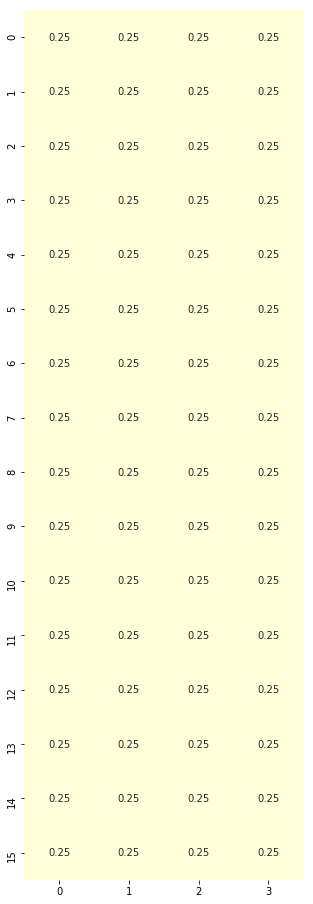

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(5, 16))
sns.heatmap(policy,  cmap="YlGnBu", annot=True, cbar=False);

### Policy Evaluation Function comprising State-value Function
- How: $\mathcal{V}_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a | s) \sum_{s' \in \mathcal{S}}  \mathcal{P}_{ss'}^a \big[\mathcal{R}_s^a + \gamma  {V}_{\pi}(s')\big]$
    - Simple code equation:
        - Values of state given policy = sum ( action probability \* transition probability \* [reward + discount \* value of new state] )
- **Aim: getting state-values**

In [25]:
import numpy as np

def policy_evaluation(env, policy, gamma=1., theta=1e-8):
    r"""Policy evaluation function. Loop until state values stable, delta < theta.
    
    Returns V comprising values of states under given policy.
    
    Args:
        env (gym.env): OpenAI environment class instantiated and assigned to an object.
        policy (np.array): policy array to evaluate
        gamma (float): discount rate for rewards
        theta (float): tiny positive number, anything below it indicates value function convergence
    """
    # 1. Create state-value array (16,)
    V = np.zeros(S_n)
    while True:
        delta = 0
        
        # 2. Loop through states
        for s in range(S_n):
            Vs = 0
            
            # 2.1 Loop through actions for the unique state
            # Given each state, we've 4 actions associated with different probabilities
            # 0.25 x 4 in this case, so we'll be looping 4 times (4 action probabilities) at each state
            for a, action_prob in enumerate(policy[s]):
                # 2.1.1 Loop through to get transition probabilities, next state, rewards and whether the game ended
                for prob, next_state, reward, done in env.P[s][a]:
                    # State-value function to get our values of states given policy
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
                    
            # This simple equation allows us to stop this loop when we've converged
            # How do we know? The new value of the state is smaller than a tiny positive value we set
            # State value change is tiny compared to what we have so we just stop!
            delta = max(delta, np.abs(V[s]-Vs))
            
            # 2.2 Update our state value for that state
            V[s] = Vs
            
        # 3. Stop policy evaluation if our state values changes are smaller than our tiny positive number
        if delta < theta:
            break
    
    return V

In [26]:
# Generate random policy with equal probabilities of each action given any state
rand_policy = generate_random_policy(S_n, A_n)

# Evaluate the policy to get state values
V = policy_evaluation(env, rand_policy)

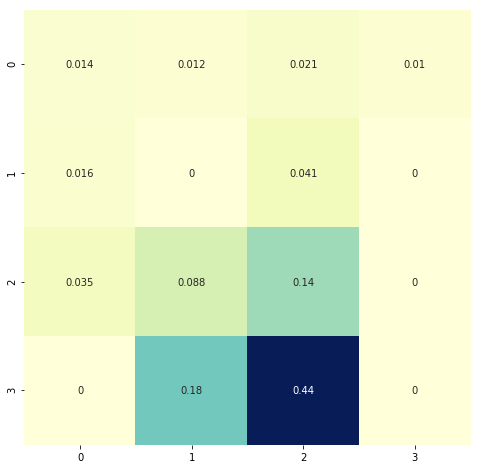

In [27]:
# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(V.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False);

In [28]:
# This is our environment
# Notice how the state values near the goal have higher values?
# Those with "H" = hole, where you die if you step, have 0 values indicating those are bad areas to be in
env.render()


SFFF
FHFH
FFFH
HFFG


## Policy Improvement

### Action-value (Q-value) function from State-value function
- How: $\mathcal{Q}_{\pi}(s, a) = \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a \big[ \mathcal{R}_s^a + \gamma  \mathcal{V}_{\pi}(s') \big]$
    - Code equation
        - Values of action = sum ( transition probability \* [reward + discount \* value of next state] )
- **Aim: getting q-values (action-values)**

In [29]:
def q_value(env, V, s, gamma=1):
    r"""Q-value (action-value) function from state-value function
    
    Returns Q values, values of actions.
    
    Args:
        env (gym.env): OpenAI environment class instantiated and assigned to an object.
        V (np.array): array of state-values obtained from policy evaluation function.
        s (integer): integer representing current state in the gridworld
        gamma (float): discount rate for rewards.
    """
    # 1. Create q-value array for one state
    # We have 4 actions, so let's create an array with the size of 4
    q = np.zeros(A_n)
    
    # 2. Loop through each action
    for a in range(A_n):
        # 2.1 For each action, we've our transition probabilities, next state, rewards and whether the game ended
        for prob, next_state, reward, done in env.P[s][a]:
            # 2.1.1 Get our action-values from state-values
            q[a] += prob * (reward + gamma * V[next_state])
            
    # Return action values
    return q

In [30]:
# For every state, we've 4 actions, hence we've 16 x 4 q values
Q = np.zeros([S_n, A_n])

# Loop through each state out of 16
# For each state, we will get the 4 q-values associated with the 4 actions
for s in range(env.nS):
    Q[s] = q_value(env, V, s)

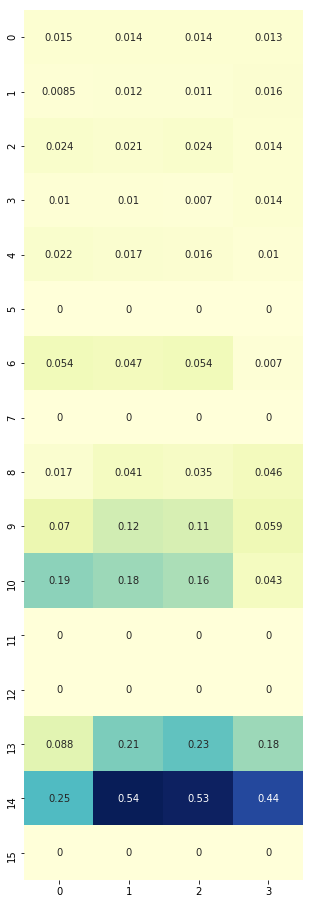

In [31]:
plt.figure(figsize=(5, 16))
sns.heatmap(Q,  cmap="YlGnBu", annot=True, cbar=False);

In [32]:
# Notice how 13/14, those in the last row of the gridworld just before reaching the goal of finishing the game, their action values are large?
env.render()


SFFF
FHFH
FFFH
HFFG


### Policy Improvement Function
- How: maximizing q-values per state by choosing actions with highest q-values
- Aim: get improved policy

In [33]:
def policy_improvement(env, V, gamma=1.):
    r"""Function to improve the policy by utilizing state values and action (q) values.
    
    Args:
        env (gym.env): OpenAI environment class instantiated and assigned to an objects
        V (np.array): array of state-values obtained from policy evaluation function
        gamma (float): discount of rewards
    """
    # 1. Blank policy
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    # 2. For each state in 16 states
    for s in range(env.nS):
        
        # 2.1 Get q values: q.shape returns (4,)
        q = q_value(env, V, s, gamma)
        
        # 2.2 Find best action based on max q-value
        # np.argwhere(q==np.max(q)) gives the position of largest q value
        # given array([0.00852356, 0.01163091, 0.0108613 , 0.01550788]), this would return array([[3]]) of shape (1, 1)
        # .flatten() reduces the shape to (1,) where we've array([3])
        best_a = np.argwhere(q==np.max(q)).flatten()
        
        # 2.3 One-hot encode best action and store into policy array's row for that state
        # In our case where the best action is array([3]), this would return
        # array([0., 0., 0., 1.]) where position 3 is the best action
        # Now we can store the best action into our policy
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

In [34]:
new_policy = policy_improvement(env, V)

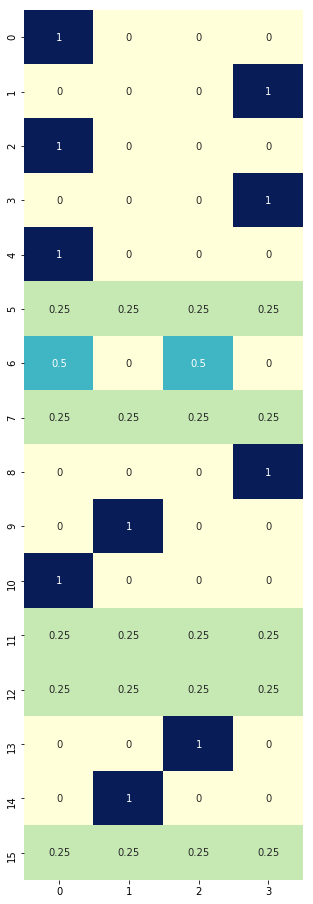

In [35]:
plt.figure(figsize=(5, 16))
sns.heatmap(new_policy,  cmap="YlGnBu", annot=True, cbar=False);

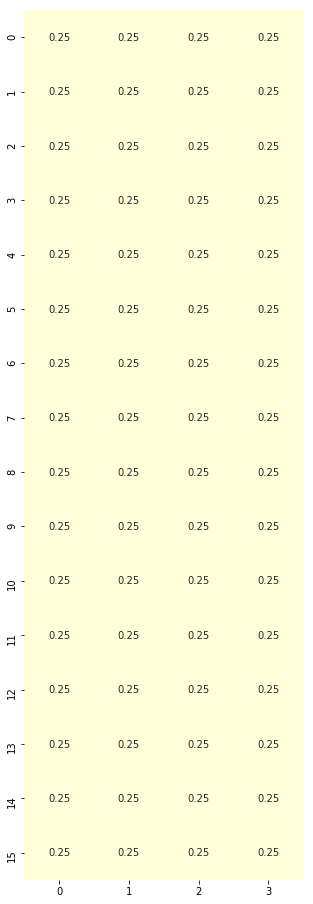

In [36]:
# Compared to this equiprobable policy, the one above is making some improvements by maximizing q-values per state
plt.figure(figsize=(5, 16))
sns.heatmap(rand_policy,  cmap="YlGnBu", annot=True, cbar=False);

### Policy Iteration Function
- How: loop through policy evaluation (get state-values) and policy improvement functions (use state-values to calculate q-values to improve policy) until optimal policy obtained
- Aim: improve policy until convergence
    - Convergence: difference of state values between old and new policies is very small (less than theta, a very small positive number)

In [37]:
import copy
def policy_iteration(env, gamma=1, theta=1e-8):
    # 1. Create equiprobable policy where every state has 4 actions with equal probabilities as a starting policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    # 2. Loop through policy_evaluation and policy_improvement functions
    while True:
        # 2.1 Get state-values
        V = policy_evaluation(env, policy, gamma, theta)
        
        # 2.2 Get new policy by getting q-values and maximizing q-values per state to get best action per state
        new_policy = policy_improvement(env, V)

        # 2.3 Stop if the value function estimates for successive policies has converged
        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta * 1e2:
            break;
        
        # 2.4 Replace policy with new policy
        policy = copy.copy(new_policy)
    return policy, V

In [38]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

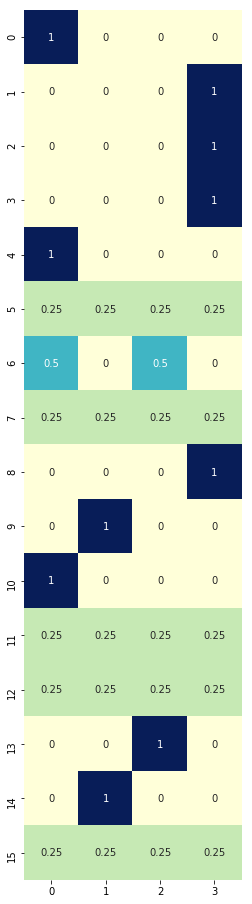

In [39]:
# Optimal policy (pi) 
# LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
plt.figure(figsize=(5, 16))
sns.heatmap(policy_pi,  cmap="YlGnBu", annot=True, cbar=False, square=True);

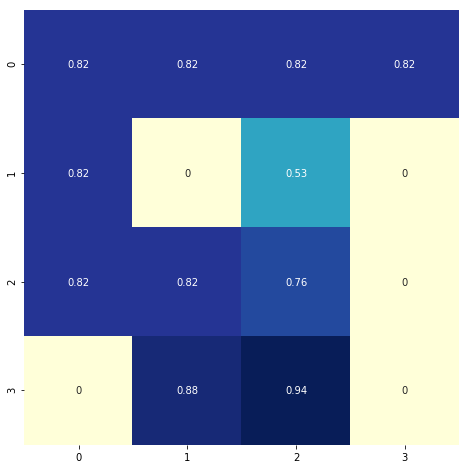

In [40]:
# State values
plt.figure(figsize=(8, 8))
sns.heatmap(V_pi.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False, square=True);

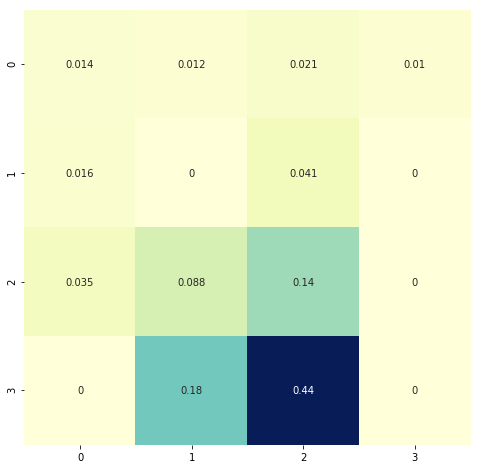

In [41]:
# State values without policy improvement, just evaluation
plt.figure(figsize=(8, 8))
sns.heatmap(V.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False);

### Value iteration
- Alternative to policy iteration
- How: loop through to find optimal value function then get one-off policy
- Aim: improve value function until convergence
    - Convergence: until difference in new and old state values are small (smaller than theta, small positive number)

In [42]:
def value_iteration(env, gamma=1, theta=1e-8):
    # 1. Create state values of shape (16,)
    V = np.zeros(env.nS)
    
    # 2. Loop through q-value function until convergence
    while True:
        delta = 0
        
        # 2.1 Loop through each state
        for s in range(env.nS):
            # 2.2 Archive old state value
            v = V[s]
            
            # 2.3 New state value = max of q-value
            V[s] = max(q_value(env, V, s, gamma))
            
            delta = max(delta, abs(V[s] - v))
        
        # 2.2 If state value changes small, converged
        if delta < theta:
            break
            
    # 3. Extract one-off policy with optimal state values
    policy = policy_improvement(env, V, gamma)
    
    return policy, V

In [43]:
policy_vi, V_vi = value_iteration(env)

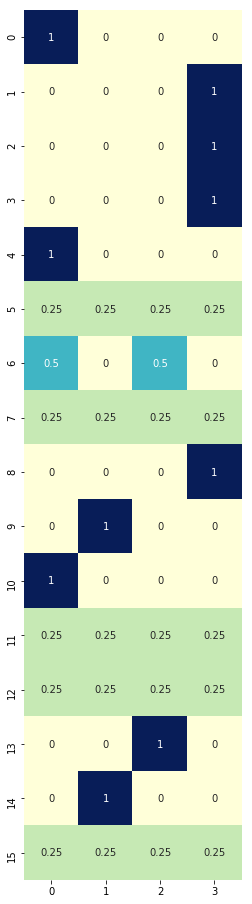

In [44]:
# Optimal policy
# LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
plt.figure(figsize=(5, 16))
sns.heatmap(policy_vi,  cmap="YlGnBu", annot=True, cbar=False, square=True);

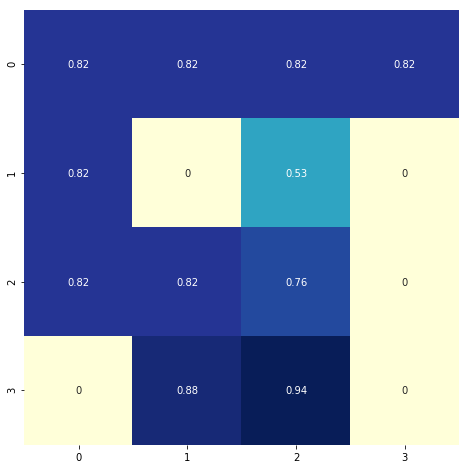

In [45]:
# State values
plt.figure(figsize=(8, 8))
sns.heatmap(V_vi.reshape(4, 4),  cmap="YlGnBu", annot=True, cbar=False, square=True);